In [46]:
import spacy 
import json
from spacy.lang.en.stop_words import STOP_WORDS 
from string import punctuation
from collections import Counter
from heapq import nlargest
from spacy.matcher import Matcher
from spacy import displacy
from IPython.display import Image, display
import visualise_spacy_tree
from spacy.lang.en import English
import networkx as nx
import matplotlib.pyplot as plt
import re
from spacy.symbols import nsubj, VERB, ADJ
import pandas as pd
import numpy as np

In [47]:
nlp=spacy.load('en_core_web_sm')

In [12]:
!python -m spacy download en

                                              0.0/12.8 MB ? eta -:--:--
                                             0.0/12.8 MB 660.6 kB/s eta 0:00:20
                                             0.1/12.8 MB 544.7 kB/s eta 0:00:24
                                             0.1/12.8 MB 657.6 kB/s eta 0:00:20
                                             0.1/12.8 MB 657.6 kB/s eta 0:00:20
                                             0.1/12.8 MB 657.6 kB/s eta 0:00:20
                                             0.1/12.8 MB 657.6 kB/s eta 0:00:20
                                             0.1/12.8 MB 361.0 kB/s eta 0:00:36
                                             0.2/12.8 MB 427.9 kB/s eta 0:00:30
                                             0.2/12.8 MB 461.0 kB/s eta 0:00:28
                                             0.2/12.8 MB 502.2 kB/s eta 0:00:26
                                             0.3/12.8 MB 477.2 kB/s eta 0:00:27
                                             0.3


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [48]:
import spacy
from collections import Counter
from string import punctuation
from heapq import nlargest

def summarize(long_rev):
    # Load the English model from spaCy
    spacy.load('en_core_web_sm')

    # Tokenize the long review
    long_rev = (long_rev)

    # #print(f"Number of sentences: {len(list(long_rev.sents))}\n")
    keyword = []
    stopwords = list(STOP_WORDS)
    pos_tag = ['PROPN', 'ADJ', 'NOUN', 'VERB']
    
    for token in long_rev:
        if token.text in stopwords or token.text in punctuation:
            continue
        if token.pos in pos_tag:
            keyword.append(token.text)
    
    freq_word = Counter(keyword)
    # #print("Filtering tokens \n")
    # #print(freq_word.most_common(5))

    # Normalization
    # Each sentence is weighed based on the frequency of the token present in each sentence
    max_freq = Counter(keyword).most_common(1)[0][1]
    for word in freq_word.keys():
        freq_word[word] = (freq_word[word] / max_freq)

    print(freq_word.most_common(5))

    # Strength of sentences
    sent_strength = {}
    for sent in long_rev.sents:
        for word in sent:
            if word.text in freq_word.keys():
                if sent in sent_strength.keys():
                    sent_strength[sent] += freq_word[word.text]
                else:
                    sent_strength[sent] = freq_word[word.text]

    # #print("sentences with their respective strengths \n")
    # #print(sent_strength)

    # the largest function returns a list containing the top 3 sentences which are stored as summarized_sentences
    summarized_sentences = nlargest(3, sent_strength, key=sent_strength.get)
    # #print("top 3 sentences with max strength ")
    # #print(summarized_sentences, "\n")

    # #print("Final Summarized Review ")
    final_sentences = [w.text for w in summarized_sentences]
    summary = " ".join(final_sentences)
    return summary

# Note: The commented print statements (#print) are removed as they were causing syntax errors.


In [49]:
import spacy
from spacy.matcher import Matcher

def find_names(text):
    names = []
    # Create a spaCy doc
    doc = nlp(text)
    
    # Define the pattern (Note: The pattern is incomplete, you need to provide the correct pattern)
    pattern = [{'LOWER': 'prime'}, {'LOWER': 'minister'}, {'POS': 'ADP', 'OP': '?'}, {'POS': 'PROPN'}]
    
    # Create a Matcher class object
    matcher = Matcher(nlp.vocab)
    matcher.add("names", None, pattern)
    matches = matcher(doc)
    
    # Find patterns in the text
    for i in range(0, len(matches)):
        # match: id, start, end
        token = doc[matches[i][1]:matches[i][2]]
        # append token to the list
        names.append(str(token))
    
    # Only keep sentences containing Indian PMs
    for name in names:
        if ((name.split()[2] == 'of') and (name.split()[3] == "India")):
            names.remove(name)
    
    return names

# Note: The code still requires correct pattern definition and importing the `nlp` object from spaCy for it to work properly.


In [50]:
def getSentences(text):
    nlp = spacy.load('en_core_web_sm')
    nlp.add_pipe('sentencizer')
    document = nlp(text)
    return [sent.text.strip() for sent in document.sents]

def printToken(token):
    print(token.text, "->", token.dep_)

def appendChunk(original, chunk):
    return original + chunk

def isRelationCandidate(token):
    deps = ["ROOT", "adj", "attr", "agent", "amod"]
    return any(subs in token.dep_ for subs in deps)

def isConstructionCandidate(token):
    deps = ["compound", "prep", "conj", "mod"]
    return any(subs in token.dep_ for subs in deps)


The Honda City is a well-balanced car with an amazing engine to drive. It runs very smoothly and rarely breaks down.


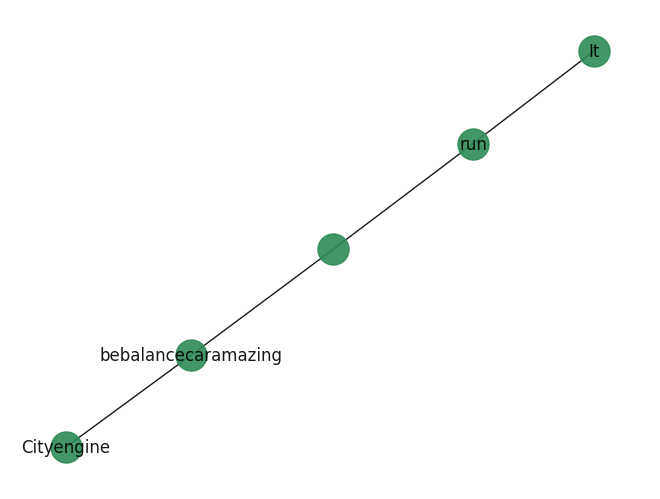

In [51]:
def processSubjectObjectPairs(tokens):
    subject = ''
    object = ''
    relation = ''
    subjectConstruction = ''
    objectConstruction = ''

    for token in tokens:
        if "punct" in token.dep_:
            continue
        
        if isRelationCandidate(token):
            relation = appendChunk(relation, token.lemma_)
        
        if isConstructionCandidate(token):
            if subjectConstruction:
                subjectConstruction = appendChunk(subjectConstruction, token.text)
            if objectConstruction:
                objectConstruction = appendChunk(objectConstruction, token.text)
        
        if "subj" in token.dep_:
            subject = appendChunk(subject, token.text)
            subject = appendChunk(subjectConstruction, subject)
            subjectConstruction = ''
        
        if "obj" in token.dep_:
            object = appendChunk(object, token.text)
            object = appendChunk(objectConstruction, object)
            objectConstruction = ''
    
    return subject.strip(), relation.strip(), object.strip()

def processSentence(sentence):
    nlp = spacy.load('en_core_web_sm')
    tokens = nlp(sentence)
    return processSubjectObjectPairs(tokens)


def printGraph(triples):
    G = nx.Graph()
    for triple in triples:
        G.add_node(triple[0])
        G.add_node(triple[1])
        G.add_node(triple[2])
        G.add_edge(triple[0], triple[1])
        G.add_edge(triple[1], triple[2])

    pos = nx.spring_layout(G)

    plt.figure()
    nx.draw(
        G,
        pos,
        edge_color='black',
        width=1,
        linewidths=1,
        node_size=500,
        node_color='seagreen',
        alpha=0.9,
        labels={node: node for node in G.nodes()}
    )
    plt.axis('off')
    plt.show()
def knowledge_graph(text):
    sentences = getSentences(text)
    nlp_model = spacy.load('en_core_web_sm')
    triples = []
    print(text)

    for sentence in sentences:
        triples.append(processSentence(sentence))

    printGraph(triples)
text = "The Honda City is a well-balanced car with an amazing engine to drive. It runs very smoothly and rarely breaks down."

# Call the knowledge_graph function with the example text
knowledge_graph(text)



In [52]:
import spacy
from spacy import displacy


In [53]:
def IE_Operations(review):
    # Create spacy doc
    doc = nlp(review)

    adjectives = set()
    verbs_all = set()

    # Applying POS to each token
    print("POS Tagging:")
    for token in doc:
        if token.pos_ not in ["SPACE", "DET", "ADP", "PUNCT", "AUX", "SCONJ", "CCONJ", "PART"]:
            print(token.text, '->', token.pos_)
            if token.pos_ == "ADJ":
                adjectives.add(token.text)
            if token.pos_ == "VERB":
                verbs_all.add(token.text)

    print("Dependency Graph:")
    print("****************************************************************************\n")

    displacy.render(doc, style='dep', jupyter=True)
    print("****************************************************************************\n")

    print("Verb with subject:")
    # Finding a verb with a subject
    verbs = set()
    for possible_subject in doc:
        if possible_subject.dep_ == "nsubj" and possible_subject.head.pos_ == "VERB":
            verbs.add(possible_subject.head.text)
    print(verbs)

    print("****************************************************************************\n")

    print("Adjectives:\n")
    print("****************************************************************************\n")

    print(adjectives)
    print("****************************************************************************\n")
    print("Named Entity Recognition (NER):")
    for ent in doc.ents:
        print(ent.text, ent.start_char, ent.end_char, ent.label_)
    print("****************************************************************************\n")


In [54]:
import re
import pandas as pd

def clean(text):
    # Removing paragraph numbers
    text = re.sub(r'[0-9]+.\t', '', str(text))
    
    # Removing new line characters
    text = re.sub(r'\n', '', str(text))
    
    # Removing apostrophes
    text = re.sub(r"'s", '', str(text))
    
    # Removing hyphens
    text = re.sub(r"-", ' ', str(text))
    
    # Removing quotation marks
    text = re.sub(r'"', '', str(text))
    
    # Removing salutations
    text = re.sub(r"Mr\.", "Mr", str(text))
    text = re.sub(r"Mrs\.", "Mrs", str(text))
    
    # Removing any reference to outside text
    text = re.sub(r"[\(\[].*?[\)\]]", "", str(text))
    
    return text


In [55]:
# Assuming you have a CSV file containing the data
df = pd.read_csv("D:/d drive/vit/nlp/project/dataset/Scrapped_Car_Reviews_Honda.csv", delimiter=',', nrows=100)

df.head()


Unnamed: 0                  Review_Date      Author_Name  \
0           0   on 03/01/17 13:11 PM (PST)      kris corah    
1           1   on 09/02/16 18:22 PM (PDT)  Carol Shafford    
2           2   on 11/12/15 08:04 AM (PST)            Gale    
3           3   on 08/13/15 15:40 PM (PDT)    Judy Eastham    
4           4   on 03/14/13 10:38 AM (PDT)  boeserkritiker    

                                       Vehicle_Title  \
0  2007 Honda Element SUV LX 4dr SUV AWD (2.4L 4c...   
1  2007 Honda Element SUV EX 4dr SUV AWD (2.4L 4c...   
2  2007 Honda Element SUV EX 4dr SUV AWD (2.4L 4c...   
3   2007 Honda Element SUV LX 4dr SUV (2.4L 4cyl 5M)   
4   2007 Honda Element SUV LX 4dr SUV (2.4L 4cyl 5A)   

                         Review_Title  \
0                QUIRKY AND PRACTICAL   
1       Go Anywhere with your Element   
2                    Such a cool car!   
3  From soup to nuts, it does it all.   
4                          good value   

                                              Review  Rating  
0   4 years with our element. Honestly there isn'...     4.0  
1   I have owned my Element since 2007 when I pur...     5.0  
2   Lowest maintenance of any vehicle I've ever o...     1.0  
3   The only thing I'd change is the drink holder...     5.0  
4   I bought this vehicle new in 2007. got 97K mi...     4.0

In [56]:
# preprocessing speeches
df['Review_clean'] = df['Review'].apply(clean)


In [57]:
# Displaying the first few rows of the DataFrame with the new 'Review_clean' column
df.head()


Unnamed: 0                  Review_Date      Author_Name  \
0           0   on 03/01/17 13:11 PM (PST)      kris corah    
1           1   on 09/02/16 18:22 PM (PDT)  Carol Shafford    
2           2   on 11/12/15 08:04 AM (PST)            Gale    
3           3   on 08/13/15 15:40 PM (PDT)    Judy Eastham    
4           4   on 03/14/13 10:38 AM (PDT)  boeserkritiker    

                                       Vehicle_Title  \
0  2007 Honda Element SUV LX 4dr SUV AWD (2.4L 4c...   
1  2007 Honda Element SUV EX 4dr SUV AWD (2.4L 4c...   
2  2007 Honda Element SUV EX 4dr SUV AWD (2.4L 4c...   
3   2007 Honda Element SUV LX 4dr SUV (2.4L 4cyl 5M)   
4   2007 Honda Element SUV LX 4dr SUV (2.4L 4cyl 5A)   

                         Review_Title  \
0                QUIRKY AND PRACTICAL   
1       Go Anywhere with your Element   
2                    Such a cool car!   
3  From soup to nuts, it does it all.   
4                          good value   

                                              Review  Rating  \
0   4 years with our element. Honestly there isn'...     4.0   
1   I have owned my Element since 2007 when I pur...     5.0   
2   Lowest maintenance of any vehicle I've ever o...     1.0   
3   The only thing I'd change is the drink holder...     5.0   
4   I bought this vehicle new in 2007. got 97K mi...     4.0   

                                        Review_clean  
0   4 years with our element. Honestly there isn'...  
1   I have owned my Element since 2007 when I pur...  
2   Lowest maintenance of any vehicle I've ever o...  
3   The only thing I'd change is the drink holder...  
4   I bought this vehicle new in 2007. got 97K mi...

In [58]:
df['Review_clean'][2]


" Lowest maintenance of any vehicle I've ever owned, but it time to move on. I don't need the large cargo space anymore to transport my wares.  Fun to drive, easy to take care of, I love the element."

In [59]:
# Extracting a subset of the 'Review_clean' column from index 0 to 9 (10 exclusive)
reviews = df['Review_clean'][0:10]

# Converting the subset to a NumPy array
reviews = np.array(reviews)

# Accessing and printing the preprocessed speech at index 8 from the NumPy array 'reviews'
print(reviews[8])


 The element lacks in features such as auto headlights, USB, power seats, sunroof, etc. The gas mileage is less than you would expect from a Honda. In all honesty I could care less about that. I absolutely love this car. Even those who give this thing lower ratings rarely cite any real material issues such as engine or transmission issues. The stereo is great for a factory set up. This is absolutely one of my favorite purchases. 


In [60]:
# Assuming 'reviews' is a list containing the preprocessed speeches from the DataFrame
# Example usage on the first review (index 0) in the 'reviews' list
IE_Operations(reviews[0])


POS Tagging:
4 -> NUM
years -> NOUN
our -> PRON
element -> NOUN
Honestly -> ADV
there -> PRON
is -> VERB
much -> ADJ
complain -> VERB
it -> PRON
I -> PRON
just -> ADV
never -> ADV
grew -> VERB
love -> VERB
it -> PRON
transmission -> NOUN
annoys -> VERB
me -> PRON
it -> PRON
constantly -> ADV
hunting -> VERB
gear -> NOUN
yes -> INTJ
I -> PRON
know -> VERB
it -> PRON
getting -> VERB
me -> PRON
best -> ADJ
mileage -> NOUN
it -> PRON
shifts -> NOUN
hard -> ADJ
harsh -> ADJ
fact -> NOUN
they -> PRON
unpleasant -> ADJ
at -> ADV
all -> ADV
I -> PRON
just -> ADV
find -> VERB
it -> PRON
annoying -> ADJ
listening -> VERB
engine -> NOUN
cycle -> NOUN
up -> ADV
down -> ADV
trans -> NOUN
constantly -> ADV
shifts -> NOUN
rise -> NOUN
dip -> NOUN
road -> NOUN
highway -> NOUN
70 -> NUM
truly -> ADV
busy -> ADJ
transmission -> NOUN
Road -> NOUN
noise -> NOUN
bit -> NOUN
loud -> ADJ
side -> NOUN
as -> ADV
well -> ADV
Crosswinds -> NOUN
fairly -> ADV
disruptive -> ADJ
pushing -> VERB
car -> NOUN
around -

****************************************************************************

Verb with subject:
{'trading', 'fell', 'annoys', 'getting', 'have', 'know', 'loves', 'decide', 'makes', 'fold', 'seen', 'open', 'find', 'take', 'grew', 'got', 'get', 'swing', 'hunting', 'held', 'love'}
****************************************************************************

Adjectives:

****************************************************************************

{'weird', 'nice', 'next', 'few', 'harsh', 'good', 'excellent', 'flat', 'faultless', 'great', 'annoying', 'simple', 'much', 'old', 'open', 'busy', 'different', 'disruptive', 'able', 'black', 'hard', 'accent', 'small', 'loud', 'unpleasant', 'rear', 'low', 'plus', 'worth', 'most', 'many', 'best', 'less'}
****************************************************************************

Named Entity Recognition (NER):
4 years 1 8 DATE
70 443 445 DATE
about 90 degrees 986 1002 QUANTITY
5 1123 1124 CARDINAL
about a year 1302 1314 DATE
about 22 23 1404 1415

In [43]:
from statistics import mean

def IE_brand(brand):
    path = "D:/d drive/vit/nlp/project/dataset/Scrapped_Car_Reviews_" + brand + ".csv"
    df = pd.read_csv(path, delimiter=',', nrows=100).sort_values(by='Rating')
    df['Rating'] = df['Review'].apply(clean)

    reviews = df['Rating'][0:5]
    reviews = list(reviews)

    print("TOP 5 REVIEWS FOR THE BRAND {} ARE:".format(brand.upper()))
    for i in range(0, 5):
        print("{}. {}".format(i+1, reviews[i]))

    review = ' '.join(reviews)
    mean = df["Rating"].mean()
    sum=summarize(review)
    
    print("\nSUMMARY REVIEW FOR THE BRAND {}: \n".format(brand.upper()))
    print(sum, '\n')

    IE_Operations(sum)

    print("MEAN SENTIMENT ASSOCIATED WITH THE BRAND {} : {}!".format(brand.upper(), mean))




In [44]:
# Call the IE_brand function for the brand 'honda'
IE_brand("Honda")


TOP 5 REVIEWS FOR THE BRAND HONDA ARE:
1.  Lowest maintenance of any vehicle I've ever owned, but it time to move on. I don't need the large cargo space anymore to transport my wares.  Fun to drive, easy to take care of, I love the element.
2.  I was so happy when I first bought my 03 element but after 2 weeks with the car, everything changed. From problems with the trothle, seats breaking apart, cluster malfunctions, brake issues, suspension problems. Engine failure. Seems this honda was a big mistake. Bought it with almost 100k, after investing more than 2k fixing problems, this car is the worst car i've had in 19 years driving. It keeps falling apart even using original parts. Never buying a Honda EVER AGAIN.
3.  We bought a 2007 Honda element  sc model silver,  18 inch mags sc package, right now it has a little under 6000 miles on it and its been in the Honda shop a total of 4 times. First it had a noise underneath the driver side, so they said it was a strut assembly. The replaced

TypeError: Could not convert  Lowest maintenance of any vehicle I've ever owned, but it time to move on. I don't need the large cargo space anymore to transport my wares.  Fun to drive, easy to take care of, I love the element. I was so happy when I first bought my 03 element but after 2 weeks with the car, everything changed. From problems with the trothle, seats breaking apart, cluster malfunctions, brake issues, suspension problems. Engine failure. Seems this honda was a big mistake. Bought it with almost 100k, after investing more than 2k fixing problems, this car is the worst car i've had in 19 years driving. It keeps falling apart even using original parts. Never buying a Honda EVER AGAIN. We bought a 2007 Honda element  sc model silver,  18 inch mags sc package, right now it has a little under 6000 miles on it and its been in the Honda shop a total of 4 times. First it had a noise underneath the driver side, so they said it was a strut assembly. The replaced under warranty which is good still the noise was there. We take it back the second time for another kind of noise on the driver side doors they adjusted them fixed for a while again back in the shop now said they hooked up some microphones all over it and found out the noise underneath is the steering rack?  So in the shop again  oh yea this thing gets very poor gas mileage, the power is lackluster and the windows are noisy When I purchased my Honda Element, I was enchanted with the uniqueness of the ride: it was a truck, SUV, and small car mixed altogether and it can get you where you want to go. It a great ride for someone who doesn't have kids and likes the great versalitity of a crossover vechile. To Pros:1) It a Honda; its gonna retain value2) Weather conditions/ off road  handles great3) Plenty interior space; could live out of it4) Crosscountry trips made easyThe Cons:1) It only a 4 seater2) Arm rest only for driver seat 3) A/C control of cabin is hard because of size4) Anything on the floor rolls up to the front because of stadium seating5) Gas mileage runs 19/22One mancar! I bought a 4WD LX model a little over a year ago. This is my fourth Honda and it is a disappointment compared to my previous Accords. I cannot see the tach or speedometer in bright sunlight even with the instrument lights on. This is just bad design. The driver seat has a wear hole in it after 15K miles. The interior plastic is cheap and scratches easily. This is a vehicle built to a low price and it shows. Pretty much solid mechanically, although recently had a $900+ starter replacement.  However, a squeaking suspension , loose sun visors that won't stay tightened, a frozen passenger lock that Honda won't replace since it didn't begin to seize until over 60,000 miles , & map light lenses that keep falling out, are some 1st yr fit & finish issues with my 2003 Element. Cons: The Element is my first Honda and probably the last. Reliability and build quality was surprisingly poor with subpar components. Tires wore out at 24,000 miles, all new brakes  at 30,000, speedometer broke at 5,000 miles, windshield replaced twice with mystery cracking, drivers seat cushioning compressed and wrinkled, and scheduled services are over priced.  The ride of the SC model is very harsh if the road is less than perfect   I had to stop drinking coffee in the car due to it too easily splashing. Brakes are noisy even shortly after replacement. Very uncomfortable for long drives due to no dead pedal.   I traded in a Toyo 4Runner for this Element. There a lot of room on the inside, especially in the back seat. Seats sit up high. Room for 4 people only. Zippy with the 5Manual trans. Plastic panels are utilitarian, easy care, no door dings. This engineer takes notes on every tank of fuel, 26MPG average. Honda replaced my A/C system 6k miles out of warranty . Happy Honda owner. I was the 1st person to have this kind of car in Texas, people looked me at as if I was from outer space or some kinda stupid to have a bread toaster looking car. But I don't mind that negative image because I was more concerned about the space and style versatility of the car. After driving this for 5 years now, I realized that I hate this car at all. I drove Nissan, Toyota, Porsche, Dodge, Chevy, Mazda and I realized the difference. There are far more better cars out there than Honda. I give credit to the reliability of this company but because of this prestige they had, they were too overconfident about their market and they made less effort of better design and worth your money to buy their car. I got the car and thought it was the best for about a year, but since then i have had 3 windshields replaced, and 2 more chipped, because the windshield is to stright. My drives seat has had to be replaced, Honda said I wore it out, not so it is made out of bad material and they won't fess up to that. Now I have had to tune up the computer so the engine light would go out. The millage lights in the dash had to be replaced. Bottom line to many things are going wrong to give this car a good review, i wish i had some of the cars these other people are talking about. I had this car for three years and about 32,000 miles, drove it across the country and in Montana for a year. The drive is good, not remarkable. The gearbox is solid and smooth. The turning radius is very good!The build quality was great, and I had no problems with the engine just regular maintenance. My only problems were with the realtime all wheel drive and the cargo capacity. This car is marketed as a young adventure vehicle. Well with a gross payload of 600ish lbs.....4 people generally hits the limit so no gear, as long as you keep it light your ok. The AWD was slow to react to slipping wheels so you start sliding on spinning wheels too often. what is the point of the tilt sunroof? Fell in love with this vehicle at the showroom and still enjoy driving it but alot of the features may not be right for everyone so do your homework if you want to buy one. I love my Honda element. This is my second one. Only issue i have is that this is the second time that the master brake cylinder went out after about 29,000 miles. It was under warranty. I also had a 2004 element and the same thing happened. Kinda odd that it would go out in my 2007 element. I think Honda should check into a internal leap problem in the master brake cylinder. Other wise, I love my element.  thanks. Poor visibility and big blind spots but  very reliable and dependable! 4 years with our element. Honestly there isn't much to complain about it, but I just never grew to love it. The transmission annoys me, it constantly hunting thru the gear, yes, I know it getting me the best mileage it can. The shifts aren't hard or harsh. In fact they aren't unpleasant at all, I just find it annoying listening to the engine cycle up and down as the trans constantly shifts at every rise or dip in the road. The highway at 70 is truly busy for the transmission. Road noise is a bit on the loud side as well. Crosswinds are fairly disruptive, pushing the car around on the road. The rear doors are a love/hate item for me as well. There is a different routine to using them in parking lots and requires some forethought. Getting in/out with kids can be an exercise in frustration. I've been trapped between the doors many times, doing some sort of dance/juggling to get into position to be able to get out from between the doors so they can be closed. The doors open about 90 degrees which makes getting in/out and loading easier but brings the doors in range of neighboring cars in parking lots. When a 5 yr old leans on the door to get out it is simple for the door to swing open enough to bump the car beside you. Aside from the low tire pressure monitor coming on and staying on about a year after we got the car it has been almost faultless. Fuel mileage is not very good. we get about 22 23 most of the time, a mile or 2 less in the winter and it will get 24+ on the highway at speed. the best mileage I've seen was 26. On the plus side, it roomy, for its size. The seats fold flat or swing up clearing most of the floor. They can be removed but I'd rather take a punch from mike Tyson. Our 5 year old loves to decorate the car by drawing on the matte black plastic panels with sidewalk chalk. It a nice conversation piece. The people at my wife work love it. It is an excellent choice for someone with small kids and/or dogs. We fold the back flat on one seat  and our great Dane lays there next to the kid in his car seat.            3 6 18. still have this thing. we will probably be trading it in the next few months when we decide on a replacement. It has held up pretty well. The seats have stains and the passenger side dash has a weird discoloration on the accent panel. The tach needle fell off about 6 months ago. there is a rust spot on the driverside rear door. all in al we got our moneys worth out of it. going on 160,000 miles. I bought this vehicle new in 2007. got 97K miles now. It has served us reliably well as you hope from a honda with 2 exceptions. right after the warranty expired we had to shell out 500 bucks to replace a rear strut that was gone. and the original battery left us stranded multiple times when it was only 3y old. . i read on blogs that many people had that problem. since it got replaced, out of my pocket, that issue is gone. the door design is weird if you have people actually using the rear seats. especially in tight parking spots. you get trapped in the space between 2 doors. it gets worse if you have to get little children out of their child seats in the rear.  great utility car! this thing can do it all without any worries. not the geatest looking car but can fill any need.the element is honestly the best snow handling car i've ever driven  I have only 64,000 miles on my Honda Element and  I still enjoy its utility. However with this low mileage I have already had a blown clutch, a blown compressor for the AC, and a persistent problem with the door locks in that the keys do not work. I have been a faithful Honda owner for many years and have always had a manual transmission.  I am a careful driver. To have over 5000 dollars in maintenance already with this low mileage is a serious test to my brand loyalty. We recently purchased our Element and have found it to be extremely useful.  The interior is more spacious than you could imagine for such a small vehicle. It is very well designed.  The only drawback so far is that we are getting about 18 MPG mixed City/HWY MPG.  To claim 21/26 is a bold statement.  Great little milk truck though. I love my E for all the features and practicality. It easy to maintain, easy to clean, and easy to own all around. It runs great with 70,000 miles, and maintenance has been minimal. I really love the waterproof seats and rubber floors. I get sand, mud and water in the car all the time from all the outdoor sports that I do. It super easy to clean the car and not worry about the mess. I also love the versatility of seating, and cargo space. It so easy to throw anything I want in the car.  The E is Uber functional, just not very fun to drive. It not fast, not sporty, doesn't handle well at high speed or in corners, but it gets me where I need to go and is reasonably comfortable. I bought the gold looking element for its looks and roominess. It looks very different from other SUV and it has great cargo room capabilities. The car has been very useful in many ways, but I have several issues with it. It has 42k miles and I have replaced both front and rear brakes and still the brakes are working poorly, I'm sure it may need additional brakes work. The tire pressure monitoring system stays on all winter, the dealer said it was normal for this car. I have replaced the windshield once, it needs a new set of tires soon, the dashboard makes cracking noises during winter, it may need alignment again. Otherwise the engine and transmission work fine.  Okay, when my Dad owned one in Silver I totally thought it looked like a toaster.  He raved about it, so when the lease on my 2004 Grand Cherokee was up I thought what the heck  Test drove the Element and the CR V and to be honest the CR V was teeny inside, my husband is 6'5 and he has plenty of room, so do my two boys.  I love the ease of a rubber floor with two kids and the special order stain proof fabric on my EX.  But most of all Mommy loves cranking up the tunes on the killer stereo system.  Super fun to drive & own.  Better than any Jeep I have ever had, more fun to drive, better gas mileage and AWD if I ever need it! I have really enjoyed this vehicle. It fun to drive and I am averaging just under 21 mpg mostly city about 25 highway.  Cargo space is great, smooth ride. Definitely recommend changing the tires to something more SUV style. I put BFG Long Trail and rides and handles much better. Truly recommend this vehicle to all. I love the design, the economical materials, the cool looks, the quick handling, the adequate power, the acceptable fuel mileage, the adequate acceleration, and the big windows . This is one heck of a vehicle  there is nothing else like it. It is  cheap, the design is way cool, the practicality is unmatched by anything short of a pickup, and it will haul four passengers. The element lacks in features such as auto headlights, USB, power seats, sunroof, etc. The gas mileage is less than you would expect from a Honda. In all honesty I could care less about that. I absolutely love this car. Even those who give this thing lower ratings rarely cite any real material issues such as engine or transmission issues. The stereo is great for a factory set up. This is absolutely one of my favorite purchases.  I was drawn to the Element by the interior flexibility and suicide doors and it doesn't look like a mini van.  My previous car, however was a Subaru Forester and I think Honda could take some lessons from Subaru on building AWD drive trains.  This car has torque steer on hard acceleration and there is a lot of wheel spin on wet pavement. Once you get the element going, it a hoot to drive.  I am interested, though, to see how this car will perform in snow .  The ABS works well which will be good for snow driving.  I miss not having the headlights turn off when I turn the ignition off, although, the warning bell has kept me out of trouble so far.  I could do without sunroof I have had my E for almost 7 months now.  Included in my 16000 miles is a 6300 miles across the US trip from GA to AK .  I towed a 1500# trailer behind it the entire way.  I have absolutely no complaints about the comfort of the seats .  The creature comforts and convenience items were well placed, easy to reach, and worked wonderful.  The utilitarianism  of the vehicle is fantastic.  We have made the decision to buy a second one to replace our other small SUV.  IMHO   you won't regret getting one. I've been a long time loyal Honda owner since I was 16.  Initially I was a bit skeptical about buying this car. After months and months of research, asking questions, test drives I bit the bullet and bought one on 1/8/07. I've had it for almost 4 months and 3800 miles later, I must say this SUV exceeded my initial expectations! I've driven in several bad snow/ice storms and this SUV just keeps goin' while the other cars and trucks are stranded on the side.  To make a long story short, if you're considering an Element, go out there and drive it, you'll definitely be impressed!!!  Super for hauling 2 mountain bikes without disassembling any bike parts   both fit fine standing up in the back with seats out or seats hanging up on the side.  Loved being able to sleep in it on road trips with all seats left in/just reclined  Super dependable in the rain and snow.  Excellent turning radius.  Doors became problematic when I had two toddlers and had to park next to other cars at the grocery store and get them in and out.  I had to replace 4 or 5 windshields because rocks caused cracks   Honda did cover the first one when we could not find a rock pock at the crack start. I love my Honda Element but the blinds spots are annoying when backing up. I have had to replace the brakes on the rear after only 17,000 miles. Honda Corp. has not followed up on my complain either to resolve the issue. I have owned many vehicles and have never had to service calipers or replace brakes with so little miles. Very disappointed in Honda in how they handled the issue.  Great handling and economy for an SUV.  Parking is never a problem and the Element turns on a dime.  Performance is adequate and it runs as smooth as a sewing machine.  We can haul our two dogs with ease and the cargo area is very versatile.   At its heart, the Element is exactly what a small SUV should be  practical, reliable, and easy to drive. What sets the car apart is simply how over the top utilitarian it really is. The interior is nearly indestructible. The rubberized floors are easy to clean, the seats are waterproof, and the folding rear seats open up a cavernous cargo area that will easily accommodate mountain bikes with the wheels still attached. For a giant rolling box, it handles surprisingly well  though not a sports car, the car feels stable and relatively nimble on mountain roads. An excellent buy for dog owners, college students, or anybody with an active lifestyle. My 2003 has 200100 miles on it. Still has the same rotors on the front, shock and struts, muffler system, and surprisingly the same spark plugs that have been checked frequently if they need replacement. Yeah, i have the frozen door lock syndrome and the drivers seat is ripped and uncomfortable, and noisy ride, but this little baby has been good to me. I will be replacing struts and brake pads etc. soon to be on the safe side. Best reliable vehicle I've ever owned. I don't know why these aren't more popular. The look is different but not ugly..it really grows on you. It a comfortable, roomy and reliable multi  purpose vehicle that sells for about $22K with AWD. People are afraid of the quirky style but they are missing out on a fun and practical vehicle. It really makes you feel young at heart regardless of age. If you are on the fence because of the way it looks, believe me, the Element will win you over. It really fun, practical and a great value! I got my SC in Galaxy Gray. I love it. It has style, and safety. Great handling. I wish it was a bit FASTER!, but for a 4 Cylinder it has pretty good kick off the line. The lower suspension than the other models is cool. but you feel the bumps more than you would like. Buttons are all easy to understand and perfectly placed. Glove box too small, but you get plenty of nooks and crannies to put your stuff at. We just bought our 2007 Element a few weeks ago, and we already can't get enough of it.  My wife and I wanted something different, and we are now the envy of all of our friends.  No one can believe how roomy it is.  There is plenty of room for your gadgetry and other tuff.'  The back seat has plenty of leg room for your guests.  Would definitely recommend for anyone that is looking to 'wow' their friends and family!  LOVE the in dash XM Satellite Radio   I don't know how we lived w/o it  before buying this car.  All of this cool stuff   AND Honda quality!  Overall grade is A+. I love my E!! I did a lot of research on this car and others, . The E was the best choice for our small but active family. I love the look, very comfortable and extremely roomy for us and our son 6 ft friends. I emailed several dealers to get pricing I was satisfied with. I love how open the car is with it big windows. It is a great priced vehicle.  I feel like I got a quality product, and can still afford to travel and put food on the table:) Insurance rate did not change too much. Other E owners have told me how great the car is in snow and ice,son can't wait to go snowboarding to see what it can do at the mt. Plenty of room for his sports and snow gear. I bought My 07 Honda Element. It has 63,000 miles on her but it drives like a brand new car. I was gonna purchased a Saturn Vue but it was promised to another buyer. It was a stroke of luck the dealer had the Element available. Yes it is a bit bouncy but I was very impressed with everything on the Element. Even being 3 almost 4 years old it was turning heads, I got the silver S C. A very handsome and very practical car. If you are looking for a Cadillac ride you wont like it. If you are looking for a great fun to drive practical people and property hauler look at the Elements. As far as the interior it is either a like or dislike. The triple design to me is a nice touch. Get one ! Thank you Honda for releasing the SC! The SC resolves the two main issues we had about the Element . Overall, we are very satisfied with our Element SC. For our needs, it is a complete package. The fact that you do not see one at every corner makes it stand out even more. Why drive a boring mini SUV when you can get the complete package w/ the Element. The Element is the ultimate utilitarian vehicle. I love the flexibility of having a large cargo area. The entire interior is easy to clean, I am never worried about getting it muddy, wet, or dirty. There is tremendous flexibility with the cargo area since the seats go up. The AWD works great, I've been through heavy snow with great results.  On long drives I fit a twin size air mattress in the back and sleep 2 people. I can fit just about anything in the back .  It seems like every inch of this car is build purely on logic. It a no frills car that is brilliant in its simplicity. Hey, it took genius to discover E=mc^2, the element follows in that tradition. I chose the EX because I did not want carpeting,just vacuum and wipe down with a sponge. EX features are worth the extra cost over the LX, map light, arm rests, stereo, ect.In Florida rainstorms,the AWD is great.I carry lots of gear and you can configure the back end many different ways.I love the feel. A bit of road noise but the sound system in the EX drowns it out. I would like better mpg.I get 19cty and 24hwy. I recommend fog lights and the optional console for extra storage space. I HATE the sunroof!  There should be a sliding cover to keep out the heat.  In Florida, my backseat passengers are cooking!  I plan on getting extra heavy tint for that. I recommend it and would buy it again. I drive a lot of miles each day and enjoy them all. After back surgery I needed something roomy and easy to get in and out of not to mention good gas mileage. My wife now wants one of her own... I was first concerned about the location of the stick shift lever.  However, the location is in a suitable place and this is not an issue.  The manual transmission aids the driver to control the vehicle and requires little effort to employ.  Both the suspension and transmission handles very well.  I preferred the manual over the automatic after test driving both vehicles.  The Elements large interior dwarfs my 1997 Grand Cherokee.  Very large or older adults can enter and exit the rear seat of the Element with ease.  The rear seats can be configured to carry various loads. This is important to both home owners and active individuals that participate in outdoor activities. I bought my 2007 Honda Element EX in May, 2007, and I've put about 3,000 miles on it so far. It run fine with no problems.  The 166 HP engine is smooth and peppy, but it isn't going to win any drag races. Fuel economy around town is only about 18 mpg, but I've been getting 29 30 mpg on the highway. This car is great for hauling my eight year old son and his gear and is great for hauling my bicycle to rides. I don't have to take the front wheel off.  I just fold one of the rear seats up on the side of the car and throw my bike in the back. The front seats are comfortable and firm. Plenty of head room . Plenty of leg room in the back seat, too. I have driven the Element in snow, off  road and on highways.  The vehicle seems to be at home wherever I go.  I am getting about 21 miles to the gallon in around town and highway mix driving. The interior is functional and is exactly what I wanted.  It allows for quick changes from passenger vehicle to cargo carrier to wet dog carrier.  The radio is outstanding and the controls on the steering wheel make driving and changing stations much easier.  Overall I would rate this as an outstanding vehicle for someone who is between getting a truck or a van and doesn't need seating for 5+.  Although I bought it used in 2012 about 6 months ago with 53,000 on the Odo, it has been very worthwhile in just about all catagories although Im used to V6 power in other vehicles it is still peppy enough for me although I did wish it got better gas mileage or maybe it is I am just not used to it? Overall in 99.9% I would give it a definate thumbs up. Its been very dependable and durable and I cant wait to try it out on the snow this year in NE Iowa. Of course I was almost sure I would love it?Its a Honda and they are known for reliability! Traded in 07 Nissan Frontier CC with 39,000 miles. Needed more space for kids. Element fits the bill. Rear seats with surprising amount of space, front seats ok. Cargo capacity just right. Engine performance pretty good, but a bit noisy. A/C nice and cold in So Cal desert. Made a good choice. We just bought our Element after many hours reviewing the vehicle. So far it has been a lot of fun for our family to drive. We wish the gas mileage was better but we are looking into that. It is just a great car and everyone loves it. We did have to put two baby sun shades side by side over the skylight, works great. Honda has a talent for making unique niche vehicles.  The CRX, the del Sol, and now the Element have provided great combination of ability, quirkiness, and practicality that could not be matched.  Even though there are many imitators today, none match the utility, configurability, comfort, and handling of the Element.  I can roll  a 5 foot long, 3 foot tall, almost four foot wide cart right into the back of the Element.  Or carry three passengers in style and comfort.  Or sleep in the back comfortably.  More headroom and legroom  than anything else I've been in.  All kinds of nifty little storage areas.  Handles much more nimbly and stably than seems possible. I had my doubts going in to the dealership and could not have been more suprised. The car drives very nicely, handles great, and has way more room than you think. I'm 6'4 210 pounds and fit with ease. OK, I confess: I did convince the dealership to put carpet, floor mats, and the SC wheels on my E. There, I said it. Notwithstanding, I really love this vehicle. With the 18s it corners better than my 2007 Camry SE  did. I am really amazed. True, it is not the most aerodynamic vehicle on the road, but it'll pass. I love the versatility of cargo space usage. I can get a lot of stuff inside, like 6 foot trees, etc. It makes trips to home improvement stores a breeze. I like that it takes up less floor space in my garage too. It odd that a vehicle with so much interior room is shorter than a Corolla. I enjoy my E. My husband recently totaled our Element. He swerved to miss a deer at 60MPH, spun out on the road berm, and the car rolled down the highway, landed on its wheels, then smashed into the ditch/hillside. The only part of the car that was not mutilated was the back hatch door. The car was smashed beyond recognition. My husband was uninjured except for a goose egg on his forehead since the drivers airbag did not go off. This vehicle held together so well that even if it held 4 people, all would most likely have been unharmed, except from flying glass. ALL this and the engine would still run. I would totally buy another Element, and plan to as soon as possible! This car is amazing! I have driven my Element in every condition imaginable over the last 3 years and love it.  Very functional interior allows for many different activities.  Hauling, camping, daily commute and more.  I average 22 mpg in everyday driving.  Factory tires are junk, replaced with Michelin, what a difference.  I recommend installing the clear protective tape on the front end to protect from chips.  I had Z  bart install for $450, covers hood, bumper and headlights and it has been worth the money.  I love this car and would recommend it to anyone who is in the market for a fun to drive, dependable all purpose vehicle.  I have a new baby and the clam shell doors are a challenge for my wife. I've had my Element for a month now so I feel I can review it. The quality is top notch, this is a well put together car. The interior is simple and roomy. The exterior is streamlined and attractive! . It drives smooth, and accelerates well for a box, you have to push it to higher RPM to really zoom, but the power is there if you need it. The shifter looks like it in a weird spot, but it really isn't if you think about it, Honda just opted for a shorter stick and a subwoofer.The sound system is amazing, you can alter your heartbeat with the bass if that your thing. The doors don't bother me, but I'm not moving kids around. Overall a great dead useful vehicle. I bought Ellie brand new and haven't regretted it one day, in fact the closer I get to pay off the more excited I am to see how many miles and years I can keep her on the road, we're only at 116,000 so far. I see us well into 250,000+. It is the most all around usable vehicle I have ever owned. It is transportation, out of the weather hauling, car camping,and a quick nap at lunchtime. She handles the snow and ice, the mountains and loves being loaded with camping gear. I see no reason to ever have any other vehicle.  I just bought my Element and love it! The gas mileage is better than I thought it would be. The arm rest is anemic but other than that, I am so happy with my new car. It is fun to have a vehicle that not everyone else has. If you want a quality, efficient vehicle with its own flare, the Element is for you!  I now have 144,000 on my 2003 Honda. This is the only car I can honestly say I like driving more each time I get behind the wheel.  I have just now had any major repairs done, and that was to replace the front end bushings, a normal maintenance item given the mileage.  My family and I have taken trips in this car and I think my 2 teens are more comfortable in this car than my wife Suburban.   I put probably 32,000 miles on my Honda in two years. I never had any problems with it. It did make a weird noise when I turned really sharp, it was not a big deal. I bought the car with about 95,000 mile on it and it did that when I bought it. The dealership said it was because of the AWD. I drove a different one a year later and it did not do that. Besides oil changes, I only spent 350.00 on it the entire time I owned it. That was for breaks and its 100,000 mile maintenance. I thought it would need a new belt, but it has a timing chain that last 300,000 miles! We really used this car for what it can be used for. Camping, hauling, animals, etc. The seats are very durable! Seats four. Have always loved Honda cars. The element is a great vehicle for me whether it getting to work on a snowy day, hauling home landscaping supplies or baby furniture, it got the space and it so easy to  clean up.  Which I also appreciate when my son make a mess in the back seat.   I purchased the Element new in 2003. It was easily the ugliest vehicle I had ever seen, but after one test drive  I bought it. Best car I've ever owned. Bought new SC in Nov.07, now have 36,000 km in 5 mos. No problems. Power/handling fine. Gas consumption fair as to be expected, but much better than previous Titan. Interior space and utility of overall vehicle unmatched by anything else out there. I have put 55,000 miles on this car and it has been a pleasure.  The Element handles extremely well in snow and out performed 4wd vehicles on a recent ski trip in the West Virginia mountains.  I drove the ELement to Miami and back and found the seats to be very comfortable and the open cabin a definite plus.  My only complaint is that I had to replace the tires at 30,000 miles.  I put Michelin tires on and they have 25,000 miles on them with very little wear.  The Element makes corrections in snow and ice that make driving in extreme conditions safe.  On the beach the Element handled well, although I didn't push it and enter the soft sand.  Overall, an outstanding utility vehicle!!!  This is the first car I have owned for more than 5 years. I think it a keeper. I live in Mexico and it the perfect vehicle for the terrain. And like all good Mexicans, you can get at least 6 adults in it   not comfortably   but none the least useful to the culture! Whenever I have it maintenanced here in Mexico, everyone at the dealership has to get inside and check it out and so do the customers   it definitely a head turner. I had a front end accident and the Element barely had a dent while the other Nissan pickup looked like a Mack truck had hit it. Even in Mexico, Honda dealerships provide excellent service! I have a 4wd/EX Sunset Orange. This is one incredible vehicle.  Perfect for my needs and one monster beast in the snow and ice.  Great interior room, looks great from outside and I can easily haul just about anything.  Love the fact no carpet to contend with, sweep and wipe and it clean.  Outstanding reliability.  I have over 35,000 miles and have had no issues whatsoever. But then it is a Honda, I expected nothing less.   I bought this car to replace a truck and a mini van.  It did that and more. Drives like a car, has the utility of a truck, and the comfort has surprised me.  I have used it for family vacations, football tailgating, commuting, hauling large items to the dump, taking the dog swimming, and kayak fishing.  I plan to go camping in it this spring.  It is without a doubt the most useful and fun vehicle to drive and own that I have ever had!!! I got my element used in 2009 and it still drove off the lot like a new car. It been noting less an absolute pleasure owning this vehicle. I moved and it would have been a nightmare if it weren't for my element. It carries more than I could imagine. It so spacious and really handles the road well. It also handles mountains well! My element handled a mountain camping trip like it was it job. I can't say enough about this car! I thought it was kind of ugly at first but after owning it for a few months, I love it so much it seems like the most beautiful looking car ever.  This is my second Honda Element, I owned a 2005 EX  and loved the car but was not impressed with the over all ride quality. Honda stepped up to the plate with the 2007 SC, this Element handles extremely well and at high speed the car is smooth and quiet. So, like everyone else... my car is my toaster.  I love my toaster but I would like to say it rides very rough.  It also much noisier than my hubby truck. but, it spacey and really fun to drive. My friends love the back seat b/c they can see what going on with the theater style seating plus it is really roomy in the back seat. easy to haul stuff too with the size and versatility. I love it, just wish it was less bumpy of a ride. I just purchased my 2007 Element a couple of weeks ago, and I love it!  It great for my two german shepherd dogs!  The back seats flip up out of the way easily and the utility floor is easy to clean.  It fun to drive, and handles well.  The interior is very spacious, with plenty of leg room for everyone.  The steering wheel mounted audio and cruise controls are easy to use.  And the XM radio is great!  The tailgate configuration in the back makes loading dogs or groceries easy.  So far, I'm averaging 24 25 mpg for a combination of city and highway driving.  Overall, I love it.  It a great, practical vehicle that fun to drive!   I needed to purchase a car with room. I've always owned sports cars.  I purchased my Ellie for a couple of reasons.  The first is because I loved the looks of it, something different, not your typical SUV.  Second is because I have a physical disability. I need to have room for my walker or when I go somewhere that I need to bring my scooter, I just have the back seats folded up and up the ramp it goes!  No problem. I bought my 2007 Honda Element SC in 06/07.  I traded in a 06 Silverado Crew Cab. My element is so much easier to drive and to park.  I get double the gas mileage also.  I still have plenty of room for passengers and luggage.  For the past several years I've traded in my car every 1 2 years but not this one.  I absolutely LOVE it.  Thank you Honda for a great vehicle! It awesome to drive too.   The new 2007 Honda Element is a pleasure to drive. It peppy, runs smoothly, and has tons of room. I knew I liked the Element when I first saw it  a few years ago. It was boxy looking but different than all the other SUVs. And the colors, esp. that unusual orange, were unique. I see people looking at it and in it sometimes. To me all the other SUVs look so much alike.  The Element, though it not so new anymore, has such a striking appearance that it maintains its uniqueness. Even your passengers have a unique ride because they're sitting high up with a great view of the road. The skylight window in the back is fun to use esp. if you're carrying dogs.  This vehicle is a riot to drive. It has so many standard features I can't list them all. It looks cool and is very useful as an utility truck. Plenty of cargo area and is a very safe car to operate.  With Honda, safety comes standard. I traded in an '07 Saturn Vue and had to take a big hit on the trade, but it was worth it.   I truly concur with the folks who LOVE their Elements. I, too, fell in love with the car when it was first featured in a Newsweek column with a photo of the very first 2002 model to hit the road. It took me 5 years to call myself the owner of an Element, but I've never looked back. I love my car. It drives like a dream! I took the back seats out so I'd have room for my dogs. I have never missed carpet. The resilient plastic flooring is ideal, especially when it comes to cleaning . But, at least when I do clean, I can do it with a bucket of soapy water and a rag  and it gleams! I can't say enough how much this is my favorite car I have owned so far, including the '03 Mercedes CLK320 I traded in for this fine SUV. I got the Nighthawk Black Pearl w/ black tinted windows, giving it a very sleek, head turning appearance. They finally fixed the grey paneled look that has kept me from fully appreciating the exterior. It rides firm, but sporty while still feeling as tight as a vault. The engine noise is not a concern at all. Acceleration is fine, since I just like to cruise in it. I already used its immense hauling capabilities each of the first 3 days I had it!  This car is a keeper!      What a great little car! I can fit my mountain bikes, snowboards, backpacking equipment and the kitchen sink if I needed to in this awesome car.  If you are a person who loves the outdoors,  this car will DEFINITELY love you too.  If you are a little bit messy   muddy or spill  prone like I am, just hose out the inside and get on with your life.  No tent?  That fine.  Just recline all the seats and sleep under the moon roof with the doors wide open.  I love how the doors swing wide open so that you can put whatever you need to in the back seat without shutting your front door and opening your back door.  Oh   and it makes a great changing room on cold snowboarding days, too! The Element has most beautiful interior  . I like especially the heavy duty flooring , removable back seats and the fabric . Element is very agile little SUV, it has excellent transmission. I really appreciate Honda for placing polymer panels  in places where Hondas notoriously rust and get bumped   the fenders , front and back over bumpers and thresholds. Element is very roomy car , it handles very nicely and I love its Boxy Lego like looks..  My element like to sip the gas though , I wonder why . But since it has 75 cubic feet cargo room it is not a tragic situation. All things considered,  the Element offers excellent value for the dollar and I am extremely happy .   The Element has most beautiful interior . I like especially the heavy duty flooring, removable back seats and the fabric . Element is a very agile little SUV, it has an excellent transmission. I really appreciate Honda for placing polymer panels  in places where Hondas notoriously rust and get bumped   the fenders, front and back over bumpers and thresholds. Element is very roomy car, it handles very nicely and I love its boxy Lego like looks.  My element likes to sip the gas though, I wonder why.  But since it has 75 cubic feet cargo room it is not a tragic situation.  All things considered,  the Element offers excellent value for the dollar and I am extremely happy.   We purchased this on a whim. We were looking into the CR Vs but when I got in it It was too small, o we checked out the Element. What a nice ride. The seats are very comfortable and the theater style seating is cool. Much better stability than most SUVs. To be honest, seeing these on the road didn't seem appealing to me, but the moment I test drove this car I was hooked. It a fun car to drive. This is the 4th Honda we have owned  and I wouldn't trade any of them for another vehicle. We got the Nighthawk black pearl. So far this is the only vehicle I have owned that I didn't noticed a ton of before and especially after purchasing on the road.  I'm so satisfied with this vehicle I will probably buy a second one later on down the road But will probably have to pry the Keys to our 2 door Civic from me. When I first saw this vehicle, I thought it was one of the ugliest vehicles on the road   I nicknamed it the toaster. My son and I went shopping with my husband for a Ridgeline.  While my husband was discussing the terms for the Ridgeline, my son and I checked out the Element.  Once we sat inside of it, we fell in love with it.  We went for a test drive that day   within two weeks I had my Element.  I love it, and now I find it quite cute.  It fun to drive, very utilitarian.  We've carted everything from a flag pole, gardening tools, plants, baseball equipment, fishing poles to our Springer Spaniel with ease.  The car makes everyday rides fun adventures.   I love this car.  It is perfect for my outdoorsy lifestyle and works great with my big dog.  I can't wait until this summer to take it on more road trips.  And can't wait to be able to camp out in it.  I love being able to fit all my gear plus my dog plus a friend and their gear in a car that gets great gas mileage. This is the most functional vehicle I've ever owned!  I'm an amateur photographer and it will easily accommodate all my gear and take me anyplace I need to go to get the shot as long as I don't need over 6.8 inches ground clearance and that the only con.  It handles great!  I sure do wish they hadn't quit making these cars or whatever you call them, SUV would probably be the better term.  Fantastic vehicle. I have owned my Element since 2007 when I purchased it NEW.   It has been a great little SUV.  Have almost 88,000 miles on it.  It will plow through snow with the best of other suvs.  I have done a lot of winter driving here in Interior Alaska, the heaters have kept me warm.  The stopping ability on icy roads is wonderful.  If they still made them I would buy a NEW one, but they don't make them anymore. I have the all wheel drive version. Am still very happy with my Element.  Am thinking about replacing it with a new rig this year, as I would like to have some of the new safety features on a vehicle I drive daily.  I think Honda made a real mistake not continuing this utilitarian vehicle.  It has been a great little car.  The newer Honda do not have the ground clearance I would like to have, we have had 80 inches of snow since December and getting around in a car with less clearance would create problems. I never really use to like the Honda Element. However after test driving one, I am hooked! I ended up buying one from Boch Honda on the Auto Mile. I LOVE how the Element handles and drives. All my friends cannot get over how much room there is on the inside. I love how easy the seats in the back fold up to create even more room. I will definitely purchase another Honda! I have 3,000 miles on my black 2007 SC and have not been dissappointed with its looks, performance, ride comfort, transporting capacity and its good looks inside & out. The XM radio performance is outstanding!  Front seating is quite cmfortable and provides very good stability in turns. The disc brakes are super smooth and stop the vehicle quickly without any nose diving or pitching.  The factory Goodyear tires give a luxury sedan ride and road grip with responsive handling.  I added a rear spoiler to top off the good looks. I would have added fog lights but they are overpriced .  You won't be disappointed at all getting an SC! Enjoy! I fell in love with the Element when the very first one came out, with the exception of the panel on the vehicle. In '07 when I saw the SC I fell in love all over again. This car may look like a toaster, but from the inside out it is an exceptional vehicle. I love the room it provides on the inside to how there no panel on the outside. I've had my SC since Nov. '06 and still have it today with over 37,000 miles on it and I haven't had to this day any problems with my SC, except taking it in for regular maintenance. I feel it one of the best investments u'll ever make and u wont regret it one bit. For everyone else who had problems I think it the driver not the car! The only thing I'd change is the drink holders. They are hard to get to with the arm down. I love  the cargo room with the seats folded up to the sides. I have brought a  50 gallon water heater home with my car and a new dishwasher. I wish they hadn't discontinued the Element I would buy a new one. My husband simply doesn't fit in other cars and I got this to ease his getting in and out. It provides him with the necessary head room. Hey Honda bring it back just like it is. SINCE I DID THE FIRST REVIEW I HAD TO GET RID OF IT. THE TRANS AXELS AND OTHER MAJOR EXPENSES HIT THIS CAR. I'D LOVE TO HAVE ANOTHER BUT I'M BURIED IN A CHEVROLET SILVERADO NOW. Gas mileage is not great on this car, everything else was super. I have the base model LX and I am very pleased with all the features.  It is very smooth, lots of pep, handling is great, and I average about 24 mpg.  This is my third Honda and the quality and reliability of all of them has been outstanding.    I have a 2003 AWD Element, bought new in '03. In my rural real estate practice, I go absolutely everywhere, and in all kind of conditions. .  I have taken it through farmer fields in knee to waist high grass and weeds in showing land. I also have five years experience in all kinds of winter weather, often driving on ice and up to ten inches or so of snow. .  I usually use an aggressive tread all  weather tire in the winter, or sometimes a mud & snow. I don't particularly overload my Element with heavy stuff in the rear, although I do keep lots of real estate stuff back there . I love my Element. It so roomy and not all cramped and confining. My husband is not a small man and in some small SUVs his head actually touches the roof and there no leg room. He is very comfortable whether riding or driving. We've taken several vacations in our Element too. Great gas mileage, fun to drive. I love how the back seats lay all the way flat, fold to the side or come completly out to create more cargo space. And when youre riding in the back the seats actually sit higher than the driver so you can see out & over the people in the front. My dog is a taxi for my two Boxers and they love to go for rides. Overall very very staisfied element owner! Only complaints are the 4 speed auto being unable to really use the powerband as effectively as the 5AT or 5MT, and the drivers seat eventually makes my back sore after a few hours.Otherwise, everything is great. 155,000+ in it with absolutely no failures. Only needs routine maintenance, which is easy to do, with exception of oil dripping on the AWD components when changing the filter .Starts the first time, every time. Goes through snow and dirt as easily as pavement. Ours has been to Burning Man five times, no issues with heavy dust exposure. Rear seats come out, and anyone 6’1” or under can sleep in the back, no problem. Rear sunroof is removable, and can be popped for great airflow. Dog loves the waterproof rear seats, and is easy to load up, since it’s easy to step into.It does 95% of anything you need it to do, and you can trust the Element to get it done. I traded my 2004 Element for a 2007.  I was surprised at how much better the 2007 edition is.  It is a nicer and safer vehicle to drive.  Even with the opportunity to get a different vehicle, the decision was easy to buy another Element.  The 2004 was great.  It amazing the things I hauled in that vehicle:  a refrigerator, 40 bags of mulch, two love seats...each time with the rear hatch closed. The day we bought our car we bought a puppy.  This is a perfect puppy car.  The back door in halves allows us to reach in and giver her a treat wthout the big door hassle.  We run around here with the dog or go to Colorado with the dog.  It is just right.  I have had 14 Lexus cars and SUVs.  Why spend the dough?  This works and runs like a clock but at half price.  I'm a fairly tall guy and when it is cold I opt for a hat.  This baby has room for me with room to spare.  I like the wash down interior.  My EX has the higher quality seat covers front and back.  Tough durable stuff. I just came from the lumber yard.  Didn't even have to pull my trailer. It is a PRACTICAL fun vehicle. When i first saw this car I thought it was the ugliest thing I had ever seen. Upon further driving and testing, it was PERFECT! The roominess has spoiled me. I can't even tell you how many times I've hauled things inside the car with the seats up and peoples jaws drop because they had no idea. Countless times I have used the suicide doors to get the kids out and people come up to my car to check it out. It a 2003!!! Don't act like you've never seen one. With two kids under 10 the rubber floors have been a Godsend! I can't tell you how many ice creams and food disasters have been avoided. Not to mention that after beach trips I just take my leaf blower and blow ALL the sand out of the car It exactly what I expected. Only car I have ever owned in which I do not get a backache amazing support on short or long trips.  Split rear door is extremely efficient infinitely better than most splits & better than all single doors. Very useful for utility, carrying big & lots of things.  Great traction in snow.  Only 3 negatives which I expected:rear seat is useful only in a pinch; had to remove headrests from rear seats to see, but don't use them anyway;choppy ride. Otherwise turning radius is great,headlights great,lots of stg places,easy to clean. Got armrest stg option, and love it. Would not suggest for young kids with carseats. Great for dogs leave backs of rear seats down always If you test drive one, you'll be hooked. Especially if you have dogs, so easy to clean. Can't get over how smooth this rides. You can haul anything and sleep in it too. Full size mattress will fit in back. Remember way back when you had a car you loved and trusted. This has that same feel Plus there are so many modifications on the market to make this your own! Cars were always simply a way to get places for me, until I bought my Element! I have 154000 miles on it. I have done basic maintenance; brakes, struts and only just did my exhaust. I do have the original clutch, tho! It does not look 9 years old, either.I only have 1 complaint and that is that Honda has stopped making it!!!I was looking forward to a second Element when I need to replace this one.I am hoping that by that time Honda will have reissued it.I love my Element so much that I convinced both my sisters to get one! I was in love with the element from day one, it took me until 2006 to finally take a look inside . I was hooked! In dec. 2006 my dealer found a 2007 kiwi lx manual I ordered and bought it on the spot, no test drive needed. I read different reviews for people wanting carpet,  different shifter location etc. For them I say get a normal car. the Element is not for everyone,  but good for children, pets, hauling things and having fun. I was shocked when i drove my element.  It drives exceedingly well, it fun to drive, and it does have a quiet ride.  I was used to range rovers, , and this is so much fun. You have developed a great car. to numeric

In [45]:
import pandas as pd
from statistics import mean

def IE_brand(brand):
    path = "D:/d drive/vit/nlp/project/dataset/Scrapped_Car_Reviews_" + brand + ".csv"
    df = pd.read_csv(path, delimiter=',', nrows=100).sort_values(by='Rating')
    df['Review_clean'] = df['Review'].apply(clean)

    review_summary = " ".join(df['Review_clean'][0:51])
    reviews = list(df['Review_clean'][0:5])

    print("TOP 5 REVIEWS FOR THE BRAND {} ARE:".format(brand.upper()))
    for i, review in enumerate(reviews, start=1):
        print("{}. {}".format(i, review))

    mean_rating = df["Rating"].mean()

    print("\nSUMMARY REVIEW FOR THE BRAND {}: \n".format(brand.upper()))
    print(review_summary, '\n')

    IE_Operations(review_summary)

    print("MEAN SENTIMENT ASSOCIATED WITH THE BRAND {} : {}".format(brand.upper(), mean_rating))



# Call the IE_brand function for the brand 'honda'
IE_brand("Honda")

TOP 5 REVIEWS FOR THE BRAND HONDA ARE:
1.  Lowest maintenance of any vehicle I've ever owned, but it time to move on. I don't need the large cargo space anymore to transport my wares.  Fun to drive, easy to take care of, I love the element.
2.  I was so happy when I first bought my 03 element but after 2 weeks with the car, everything changed. From problems with the trothle, seats breaking apart, cluster malfunctions, brake issues, suspension problems. Engine failure. Seems this honda was a big mistake. Bought it with almost 100k, after investing more than 2k fixing problems, this car is the worst car i've had in 19 years driving. It keeps falling apart even using original parts. Never buying a Honda EVER AGAIN.
3.  We bought a 2007 Honda element  sc model silver,  18 inch mags sc package, right now it has a little under 6000 miles on it and its been in the Honda shop a total of 4 times. First it had a noise underneath the driver side, so they said it was a strut assembly. The replaced

POS Tagging:
Lowest -> ADJ
maintenance -> NOUN
vehicle -> NOUN
I -> PRON
ever -> ADV
owned -> VERB
it -> PRON
time -> NOUN
move -> VERB
I -> PRON
need -> VERB
large -> ADJ
cargo -> NOUN
space -> NOUN
anymore -> ADV
transport -> VERB
my -> PRON
wares -> NOUN
Fun -> PROPN
drive -> VERB
easy -> ADJ
take -> VERB
care -> NOUN
I -> PRON
love -> VERB
element -> NOUN
I -> PRON
so -> ADV
happy -> ADJ
I -> PRON
first -> ADV
bought -> VERB
my -> PRON
03 -> NUM
element -> NOUN
2 -> NUM
weeks -> NOUN
car -> NOUN
everything -> PRON
changed -> VERB
problems -> NOUN
trothle -> PROPN
seats -> NOUN
breaking -> VERB
apart -> ADV
cluster -> NOUN
malfunctions -> NOUN
brake -> NOUN
issues -> NOUN
suspension -> NOUN
problems -> NOUN
Engine -> NOUN
failure -> NOUN
Seems -> VERB
honda -> NOUN
big -> ADJ
mistake -> NOUN
Bought -> VERB
it -> PRON
almost -> ADV
100k -> NOUN
investing -> VERB
more -> ADJ
2k -> PROPN
fixing -> VERB
problems -> NOUN
car -> NOUN
worst -> ADJ
car -> NOUN
i -> PRON
had -> VERB
19 -> NU

****************************************************************************

Verb with subject:
{'fell', 'lacks', 'realized', 'say', 'grows', 'believe', 'provided', 'lived', 'told', 'getting', 'hope', 'follows', 'put', 'wanted', 'know', 'hate', 'see', 'loves', 'resolves', 'took', 'makes', 'fold', 'seen', 'recommend', 'take', 'plan', 'chose', 'grew', 'haul', 'expired', 'expect', 'replace', 'hits', 'followed', 'live', 'feels', 'purchased', 'sit', 'fun', 'works', 'sells', 'start', 'gon', 'gets', 'love', 'dwarfs', 'aids', 'participate', 'trading', 'corners', 'make', 'annoys', 'shows', 'turn', 'has', 'wore', 'HATE', 'drive', 'made', 'stay', 'fits', 'miss', 'going', 'look', 'like', 'check', 'stand', 'traded', 'drove', 'needed', 'rate', 'looked', 'carry', 'served', 'mind', 'hooked', 'turns', 'left', 'missing', 'wait', 'used', 'swing', 'turning', 'dings', 'held', 'run', 'accommodate', 'looking', 'keeps', 'became', 'drowns', 'read', 'towed', 'give', 'feel', 'configure', 'think', 'enjoyed', 're